# CS 505 Project

Team member: Shuo Wang


In this document, I will develop 2 language models, one in N-grams model and one in neural network model. I will train two models with both Chinese corpus and English corpus and compare how they perform. The corpus I use in this file can be found in the same zip folder with this document. You can modify some of the code to run it by youself.

In [169]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from transformers import BertTokenizer, BertForMaskedLM


# Import the Corpus

Both corpus are from Universal Dependencies 2.13. They offer txt files for the same content in different languages, so two corpus will be relatively similar to each other. This is good for this project comparing to using other corpus because when I explore how different languages affect the language models, the uncertainty brought by the actual content of the message should be minimized, and having the same content does that perfectly

Here's the link for the Universal Dependencies 2.13: https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-5287

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# English corpus
english_corpus = "/content/drive/MyDrive/CS505 Project/en_pud-ud-test.txt"

# Tokenizing English corpus
tokenizer_en = BertTokenizer.from_pretrained('bert-base-uncased')
with open(english_corpus, 'r', encoding='utf-8') as file_en:
    text_en = file_en.read()
tokenized_text_en = tokenizer_en.tokenize(text_en)
indexed_tokens_en = tokenizer_en.convert_tokens_to_ids(tokenized_text_en)
tokens_tensor_en = torch.tensor([indexed_tokens_en])

In [64]:
# Chinese corpus
chinese_corpus = "/content/drive/MyDrive/CS505 Project/zh_pud-ud-test.txt"

# Tokenizing Chinese corpus
tokenizer_cn = BertTokenizer.from_pretrained('bert-base-chinese')
with open(chinese_corpus, 'r', encoding='utf-8') as file_cn:
    text_cn = file_cn.read()
tokenized_text_cn = tokenizer_cn.tokenize(text_cn)
indexed_tokens_cn = tokenizer_cn.convert_tokens_to_ids(tokenized_text_cn)
tokens_tensor_cn = torch.tensor([indexed_tokens_cn])

In [65]:
print(text_en[:1000])

“While much of the digital transition is unprecedented in the United States, the
peaceful transition of power is not,” Obama special assistant Kori Schulman
wrote in a blog post Monday. For those who follow social media transitions on
Capitol Hill, this will be a little different. 

But in a break from his past rhetoric about curtailing immigration, the GOP
nominee proclaimed that as president he would allow “tremendous numbers” of
legal immigrants based on a “merit system.” “So I hate to put a little pressure
on you, but the fate of the republic rests on your shoulders,” he told the crowd
gathered on a sports field at the University of North Carolina. The new spending
is fueled by Clinton’s large bank account. What she’s saying and what she’s
doing, it — actually, it’s unbelievable. 

$5,000 per person, the maximum allowed. In early October, the transition team
used the same venue to meet with technology lobbyists, inviting representatives
from Uber, the Motion Picture Association of 

If you cannot read Chinese, the following content is a direct translation of the English content above. The phrase "奧巴馬" means "Obama"......

In [66]:
print(text_cn[:400])

"雖然美國的許多數字化轉型都是史無前例的，但權力的和平轉移卻存在先例，”奧巴馬的特別助理科瑞·舒爾曼在周一發布的博客中寫道。 

對於通過社交媒體來跟踪國會山任職變遷的人而言，這次與以往有所不同。 

但是，他在過去的一次進行移民削減相關演說的休息環節，作為共和黨候選人，他曾宣稱，作為總統，基於政績的考量他將允許“超大量”合法移民。 

“所以我不想給你們施加哪怕一丁點的壓力，但你們肩負的是共和國的命運，”奧巴馬對在北卡羅來納大學運動場上的群眾說道。 

希拉里的巨額銀行帳戶使政府支出的突破了新上限。 

她的所言所行，簡直令人難以置信。 

最高限額為每人5,000美元。 

在十月初，政權轉移團隊在同一場地，會見了技術團隊的說客代表，他們分別來自Uber公司、美國電影協會、美國消費科技協會及其他團體。 

這次集會原本定在幾個街區之外的H街上華盛頓的私人大都會俱樂部舉行。 

也許著裝


Here's the takenized text of both corpus:

In [67]:
print(tokenized_text_en[:100])

['“', 'while', 'much', 'of', 'the', 'digital', 'transition', 'is', 'unprecedented', 'in', 'the', 'united', 'states', ',', 'the', 'peaceful', 'transition', 'of', 'power', 'is', 'not', ',', '”', 'obama', 'special', 'assistant', 'ko', '##ri', 'sc', '##hul', '##man', 'wrote', 'in', 'a', 'blog', 'post', 'monday', '.', 'for', 'those', 'who', 'follow', 'social', 'media', 'transitions', 'on', 'capitol', 'hill', ',', 'this', 'will', 'be', 'a', 'little', 'different', '.', 'but', 'in', 'a', 'break', 'from', 'his', 'past', 'rhetoric', 'about', 'curt', '##ailing', 'immigration', ',', 'the', 'go', '##p', 'nominee', 'proclaimed', 'that', 'as', 'president', 'he', 'would', 'allow', '“', 'tremendous', 'numbers', '”', 'of', 'legal', 'immigrants', 'based', 'on', 'a', '“', 'merit', 'system', '.', '”', '“', 'so', 'i', 'hate', 'to']


In [68]:
print(tokenized_text_cn[:100])

['"', '雖', '然', '美', '國', '的', '許', '多', '數', '字', '化', '轉', '型', '都', '是', '史', '無', '前', '例', '的', '，', '但', '權', '力', '的', '和', '平', '轉', '移', '卻', '存', '在', '先', '例', '，', '[UNK]', '奧', '巴', '馬', '的', '特', '別', '助', '理', '科', '瑞', '·', '舒', '爾', '曼', '在', '周', '一', '發', '布', '的', '博', '客', '中', '寫', '道', '。', '對', '於', '通', '過', '社', '交', '媒', '體', '來', '跟', '踪', '國', '會', '山', '任', '職', '變', '遷', '的', '人', '而', '言', '，', '這', '次', '與', '以', '往', '有', '所', '不', '同', '。', '但', '是', '，', '他', '在']


Note that since two corpus are in different languages, the length of the text is very different:

In [69]:
len(text_cn)

38581

In [70]:
len(text_en)

111914

Chinese version is more concise than English version. Its length is almost one third of the English corpus length. This could potentially influence the performance of the language model?

# Building N-gram Model

We will first try N-grams and see how different two language can be. In Chinese, many words have different meanings when they are put together with other words. For example, "发布" means "publish (verb)" and "发现" means "discover (verb)". Some of the phrase is fixed, meaning no other combination of words can appear beside the given combination. By using N-grams, the probability of certain combinations appearing in the predictions should be much more higher than other combinations after we train the model. A word in English would become a pharse in Chinese.

In [71]:
# process the corpus
en_processed = text_en.replace('\n',' ').replace('“','').replace('”','').replace('"','')

# split the corpus into sentences
en_sentence = []
ls = en_processed.split('; ')
for i in ls:
    en_sentence += i.split('! ')
ls = []
for i in en_sentence:
    ls += i.split('? ')
en_sentence = []
for i in ls:
    en_sentence += i.split('. ')

# split sentences into words
en_sent = []
for sent in en_sentence:
    sentence = sent.replace(',',' ').split()
    sentence = ['<s>'] + sentence + ['</s>']
    en_sent.append(sentence)
print(en_sent[0])

['<s>', 'While', 'much', 'of', 'the', 'digital', 'transition', 'is', 'unprecedented', 'in', 'the', 'United', 'States', 'the', 'peaceful', 'transition', 'of', 'power', 'is', 'not', 'Obama', 'special', 'assistant', 'Kori', 'Schulman', 'wrote', 'in', 'a', 'blog', 'post', 'Monday', '</s>']


In [72]:
# process the corpus
cn_processed = text_cn.replace('\n',' ').replace('“','').replace('”','').replace('"','').replace('：',' ').replace('、', ' ').replace('《',' ').replace('》',' ')

# split the corpus into sentences
cn_sentence = []
ls = cn_processed.split('；')
for i in ls:
    cn_sentence += i.split('！')
ls = []
for i in cn_sentence:
    ls += i.split('？')
cn_sentence = []
for i in ls:
    cn_sentence += i.split('。')
cn_sentence

# split sentences into words
cn_sent = []
for sent in cn_sentence:
    sentence = sent.replace('，','').replace(',','').replace(' ','')
    ls =  ['<s>']
    for i in sentence:
        ls.append(i)
    ls.append('</s>')
    cn_sent.append(ls)
print(cn_sent[0])

['<s>', '雖', '然', '美', '國', '的', '許', '多', '數', '字', '化', '轉', '型', '都', '是', '史', '無', '前', '例', '的', '但', '權', '力', '的', '和', '平', '轉', '移', '卻', '存', '在', '先', '例', '奧', '巴', '馬', '的', '特', '別', '助', '理', '科', '瑞', '·', '舒', '爾', '曼', '在', '周', '一', '發', '布', '的', '博', '客', '中', '寫', '道', '</s>']


The number of sentences in the corpus:

In [73]:
# English
len(en_sent)

1041

In [74]:
# Chinese
len(cn_sent)

1026

The number of sentences are similar since the contents of both corpus are the same. This will reduce some of the differences in two models. For instance, the number of choices we have when model starts a sentence is limited and will have similar meanings. But there will be differences caused by length of phrases and reordering of sentences. We will see this later when we create sentences.

In order to measure the performance of the model, we split the corpus into traning set and testing set. To make it fair between two languages, we will make the testing set to be the **last 5% of the sentences**. That way, the testing set will have the same content and thus making the comparison fair, relatively speaking...

In [75]:
# split into testing set and traning set
en_test_set = en_sent[-len(en_sent)//20:]
en_sent = en_sent[:-len(en_sent)//20]

print("number of sentences in the traning set", len(en_sent))

number of sentences in the traning set 988


In [76]:
cn_test_set = cn_sent[-len(cn_sent)//20:]
cn_sent = cn_sent[:-len(cn_sent)//20]

print("number of sentences in the traning set", len(cn_sent))

number of sentences in the traning set 974


In [77]:
from nltk import ngrams

def build_ngram_model(corpus, n):
    ngram = defaultdict(lambda: defaultdict(int))
    for sentence in corpus:
        for i in ngrams(sentence, n):
            prefix = ' '.join(i[:n-1])
            suffix = i[n-1]
            ngram[prefix][suffix] += 1
    return ngram

en_ngram_model = [None,None,build_ngram_model(en_sent, 2),build_ngram_model(en_sent, 3),build_ngram_model(en_sent, 4)]
cn_ngram_model = [None,None,build_ngram_model(cn_sent, 2),build_ngram_model(cn_sent, 3),build_ngram_model(cn_sent, 4)]

print('example English 2-gram: the 2-gram for the word "while" \n',en_ngram_model[2]['while'])
print('example Chinese 2-gram: the 2-gram for the word "雖" \n',cn_ngram_model[2]['雖'])

example English 2-gram: the 2-gram for the word "while" 
 defaultdict(<class 'int'>, {'nine': 1, 'its': 1, 'manipulating': 1, 'a': 2, 'filming': 1, 'others': 1, 'Piaf': 1, 'leaders': 1, 'the': 1})
example Chinese 2-gram: the 2-gram for the word "雖" 
 defaultdict(<class 'int'>, {'然': 5})


Note that there are 7 possible words following **"while"** in the English corpus, but only 1 possible word following **"雖"** in the Chinese corpus. That is because in Chinese, **"while"** can be directly translated into **"雖然"**.

Some English words could become several words when translated into Chinese, and that will change the performance of N-gram model. Some combinations will become fixed, and therefore allowing the model to generate sentences that knows how to use certain phrase. But it also becomes an issue because the fixed phrase will cost more position in N-grams, just like we can have the probability of words following "while" in 2-gram model in English, but we will have to have at least 3-gram model in Chinese to get the same probability.

Another issue is when two phrase share the same word in a sequential manner. For example, **"雖然"** and **"然而"** share the same word **"然"**. When the 2-gram model generate the next word of **"然"**, it will likely choose **"而"** since fixed phrases appear more offen in the corpus than random word follow after a fixed phrase. That will create **"雖然而"** which makes no sense at all. So we have to come up with a more reliable way to generate a sentence using N-gram model.

In [78]:
# the traditional random generator for n-gram model
def generate_sentence(ngram_model, n, max_length=50):
    if n > 4:
      print('Sorry, the largest n-gram we have is 4!')
    sentence = ['<s>']
    current_length = 1
    # first word
    prefix = ' '.join(sentence)
    if prefix in ngram_model[2]:
        choices = list(ngram_model[2][prefix].items())
        next_word = random.choices(*zip(*choices))[0]
        if next_word == '</s>':
            return ' '.join(sentence[1:])
        sentence.append(next_word)
        current_length += 1
    else:
        return ' '.join(sentence[1:])
    # second word
    prefix = ' '.join(sentence)
    if prefix in ngram_model[3]:
        choices = list(ngram_model[3][prefix].items())
        next_word = random.choices(*zip(*choices))[0]
        if next_word == '</s>':
            return ' '.join(sentence[1:])
        sentence.append(next_word)
        current_length += 1
    else:
        return ' '.join(sentence[1:])
    # after second word
    while current_length <= max_length:
        prefix = ' '.join(sentence[-(n-1):])
        if prefix in ngram_model[4]:
            choices = list(ngram_model[4][prefix].items())
            next_word = random.choices(*zip(*choices))[0]
            if next_word == '</s>':
                break
            sentence.append(next_word)
            current_length += 1
        else:
            break
    return ' '.join(sentence[1:])


en_generated_sentence = generate_sentence(en_ngram_model, 4)
print("Generated English Sentence:\n", en_generated_sentence)
cn_generated_sentence = generate_sentence(cn_ngram_model, 4)
print("Generated Chinese Sentence:\n", cn_generated_sentence)

Generated English Sentence:
 One expects a bump from the booming real estate market and increasing federal expenditures
Generated Chinese Sentence:
 它 帶 有 一 個 很 棒 的 團 隊 這 是 我 們 最 後 一 個 日 期 只 能 是 一 個 昂 貴 的 標 準 還 是 預 付 款 收 費 制


# Evaluation

Now that we have 2 ngram models trained by 2 corpus, we can evaluate them and compare their performance. We will use perplexity to judge how well the sentences are.

In [79]:
def calculate_perplexity(ngram_model, test_set, n):
    total_log_prob = 0
    total_words = 0
    probability = []
    for sentence in test_set:
        for i in range(n - 1, len(sentence)):
            prefix = sentence[i - n + 1:i]
            word = sentence[i]
            if ' '.join(prefix) in ngram_model[n] and word in ngram_model[n][' '.join(prefix)]:
                p = np.log2(ngram_model[n][' '.join(prefix)][word] / sum(ngram_model[n][' '.join(prefix)].values()))
                probability += [p]
                total_log_prob -= p
                total_words += 1
            elif n>= 3 and ' '.join(prefix[1:]) in ngram_model[n-1] and word in ngram_model[n-1][' '.join(prefix[1:])]:
                p = np.log2(ngram_model[n-1][' '.join(prefix[1:])][word] / sum(ngram_model[n-1][' '.join(prefix[1:])].values())) * 0.4
                probability += [p]
                total_log_prob -= p
                total_words += 1
            elif n== 4 and ' '.join(prefix[2:]) in ngram_model[n-2] and word in ngram_model[n-2][' '.join(prefix[2:])]:
                p = np.log2(ngram_model[n-2][' '.join(prefix[2:])][word] / sum(ngram_model[n-2][' '.join(prefix[2:])].values())) * 0.4 * 0.4
                probability += [p]
                total_log_prob -= p
                total_words += 1
            else:
                total_log_prob -= np.log2(1e-10)
                total_words += 1

    return 2 ** (total_log_prob / total_words), probability

##Evaluating under 2-gram model:

In [80]:
# perplexity using 2-gram
en_perplexity_2,en_p = calculate_perplexity(en_ngram_model, en_test_set, 2)
cn_perplexity_2,cn_p = calculate_perplexity(cn_ngram_model, cn_test_set, 2)

print("English Model Perplexity:", en_perplexity_2)
print("Chinese Model Perplexity:", cn_perplexity_2)
print("Perplexity Ratio (CN/EN):", cn_perplexity_2/en_perplexity_2)

print()
print("Variance of English Probabilities: ", np.var(en_p))
print("Variance of Chinese Probabilities: ", np.var(cn_p))

English Model Perplexity: 45464593.80359401
Chinese Model Perplexity: 80332.52887042328
Perplexity Ratio (CN/EN): 0.0017669250322010562

Variance of English Probabilities:  9.196925708914018
Variance of Chinese Probabilities:  5.0369420079002944



**Perplexity:**

The perplexity of Chinese model appears to be way lower than the perplexity of English model. The Chinese model seems to perform better than the English model.



**Variance:**

The variance of probabilities for individual words is significantly lower for the Chinese model compared to the English model, which  indicates that the Chinese model tends to provide more consistent and stable predictions for individual words across different contexts or sequences.



##Evaluating under 4-gram model:

In [81]:
# perplexity using 4-gram
en_perplexity_4,en_p_4 = calculate_perplexity(en_ngram_model, en_test_set, 4)
cn_perplexity_4,cn_p_4 = calculate_perplexity(cn_ngram_model, cn_test_set, 4)

print("English Model Perplexity:", en_perplexity_4)
print("Chinese Model Perplexity:", cn_perplexity_4)
print("Perplexity Ratio (CN/EN):", cn_perplexity_4/en_perplexity_4)

print()
print("Variance of English Probabilities of each word: ", np.var(en_p_4))
print("Variance of Chinese Probabilities of each word: ", np.var(cn_p_4))

English Model Perplexity: 39767190.95838607
Chinese Model Perplexity: 27612.79533829876
Perplexity Ratio (CN/EN): 0.000694361222727395

Variance of English Probabilities of each word:  0.3218205559705075
Variance of Chinese Probabilities of each word:  0.306964987046002


In [82]:
print("English Model Perplexity Increase Percentage:", -(en_perplexity_4-en_perplexity_2) / en_perplexity_2 * 100)
print("Chinese Model Perplexity Increase Percentage:", -(cn_perplexity_4-cn_perplexity_2) / cn_perplexity_2 * 100)

English Model Perplexity Increase Percentage: 12.53151599642699
Chinese Model Perplexity Increase Percentage: 65.62688150545053


In [83]:
print("English Model Variance Increase Percentage:", -(np.var(en_p_4)-np.var(en_p)) / np.var(en_p) * 100)
print("Chinese Model Variance Increase Percentage:", -(np.var(cn_p_4)-np.var(cn_p)) / np.var(cn_p) * 100)

English Model Variance Increase Percentage: 96.50078117235864
Chinese Model Variance Increase Percentage: 93.90572719390978


The perplexity ratios (CN/EN) for both 2-gram and 4-gram models confirm that the Chinese model performs substantially better than the English model on the test data.

**Changes:**

After shifting to 4-grams, the performances of both models increase a lot. However, the percentage increase of Chinese model is more than that of English model. This suggests that the predictive performance of Chinese model is more affected by the length of grams.

In both cases, the variances of probabilities for individual words increase as well, but the percentage increase and the final value of both models are very close. In higher grams, English model can also provide a stable prediction. But the influence in perplexity is not as drastic. This could mean that the accuracy of prediction in English model is less related to the length of grams.

Hence, the predictive performance of Chinese model could be more sensitive to the context size than the predictive performance of English model. **N-gram model could be more suitable for Chinese than English.**

However, the drastic increase in the performance indicts that the number of possible word choices under a huge context could be less for Chinese. This means the possible variations of the language is less for Chinese.

##**Is this implying that Chinese is more "stiff" than English?**

I don't think so. Existing materials have shown Chinese can be very versatile. The number of Chinese literature is uncountable. It would be unreasonable to say that Chinese does not allow innovations.

Then why is N-gram model indicating that the performance of Chinese N-gram model is more subject to the size of context? I have a few hypotheses:

1. **Dataset:** this phenomenon may be caused by lack of data. The training corpus contains 1026 sentences, which is too small to represent the entire Chinese language. So it's merely an coincidence.

2. **Chinese phrases:** like mentioned earlier, Chinese language has vast amout of fixed phrase. The length of such phrase varies a lot. From 2-word expressions to 7-word poems, Chinese people enjoy quoting from historical sentences. The amount of 4-word idioms is uncountable. By using larger grams, the model is able to capture those fixed phrases and make predictions based on that.

3. **Polysemy:** like English, Chinese words could have multiple meanings. The way two languages exhibit this aspect is different. Chinese people like to express their thoughts in as few words as they can. Historical literature often uses poem-like expressions to describe the situation. Many words are used constantly but have different meanings. So the model could misunderstand the meaning of sentences, but since the word appear in the traning set, it will still count that as within the prediction, thus making the probability a lot higher.

In this case, I believe reason one is the best explanation. But further exploration is needed to determine the actually reason.

# Building Neural Network Model

Now let's build a neural network model and see how it behaves giving two languages.

In [162]:
import random
import torch.nn as nn
import torch.optim as optim
import nltk
from nltk.corpus import gutenberg

class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.long)

class SentenceGenerationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SentenceGenerationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        output, hidden = self.lstm(embedded.permute(1, 0, 2), hidden)
        output = self.linear(output)
        return output.permute(1, 0, 2), hidden

def generate_sentence(model,vocab,start_token='<s>', max_length=100):
    model.eval()
    current_token = start_token
    sentence = [current_token]

    with torch.no_grad():
        while current_token != '</s>' and len(sentence) < max_length:
            input_tensor = torch.tensor([[vocab[current_token]]], dtype=torch.long)
            hidden = (torch.zeros(1, 1, hidden_dim),
                      torch.zeros(1, 1, hidden_dim))
            output, hidden = model(input_tensor, hidden)
            output_probs = torch.softmax(output.squeeze(), dim=0)
            predicted_index = torch.multinomial(output_probs, 1).item()
            current_token = list(vocab.keys())[list(vocab.values()).index(predicted_index)]
            sentence.append(current_token)

    return ' '.join(sentence)

##English

100%|██████████| 3/3 [01:13<00:00, 24.38s/it]


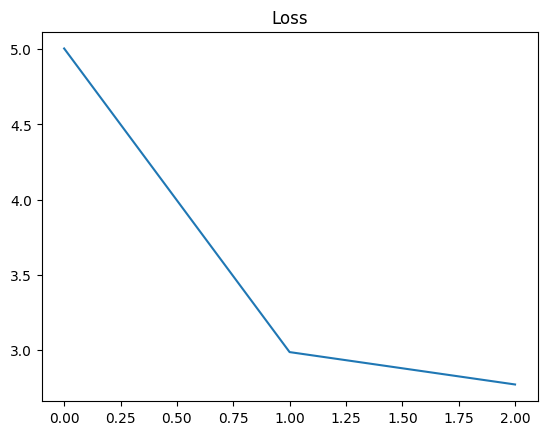

In [163]:
sentences = en_sent

max_sentence_length = max([len(sent) for sent in sentences])
padded_sentences = [sent + ['<pad>'] * (max_sentence_length - len(sent)) for sent in sentences]

en_vocab = {'<pad>': 0, '<s>': 1, '</s>': 2}
idx = 3
for sent in padded_sentences:
    for word in sent:
        if word not in en_vocab:
            en_vocab[word] = idx
            idx += 1

indexed_sentences = [[en_vocab[word] for word in sent] for sent in padded_sentences]

# Initialize the model
vocab_size = len(en_vocab)
embedding_dim = 100
hidden_dim = 128
en_model = SentenceGenerationModel(vocab_size, embedding_dim, hidden_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(en_model.parameters(), lr=0.001)

# Training loop
dataset = SentenceDataset(indexed_sentences)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

losses = []

num_epochs = 3 # seems to be the sweet spot!
for epoch in tqdm(range(num_epochs)):
    for batch in dataloader:
        optimizer.zero_grad()
        batch_input = batch[:, :-1]
        batch_target = batch[:, 1:]
        hidden = (torch.zeros(1, batch.size(0), hidden_dim),
                  torch.zeros(1, batch.size(0), hidden_dim))

        output, _ = en_model(batch_input, hidden)
        loss = criterion(output.permute(0, 2, 1), batch_target)
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
plt.title('Loss')
plt.plot(losses)

In [164]:
generated_sentence = generate_sentence(en_model,en_vocab)
print(generated_sentence)

<s> news Archbishop quest quoted amazing agreed tailor-made kill he's 27th European numerous suggest Scritti sense paralysis Walt contingent blast AKP's Later factual full Kristiansand Greeks switched rental taxpayers animated beer Greeks critical outbreak manner chaos Post-Classic Islands Abbotsford martial context December whereabouts waterway joint scan roles laboratory meetings winner 1927 took ecosystem Four hammer monument decline IV grow courtship ZEIT Premium Bananas suspect Finland Japanese aside economical Germaine's marched unlimited disapproval father's frequent GM cracked - Cameroon goods writer reimburse denied clause volcanoes touch exchange portrayal km typeset soon 2019 interpreted dinosaurs Colorado ends Institute's can't sexist emails capita


##Chinese

100%|██████████| 3/3 [00:56<00:00, 18.84s/it]


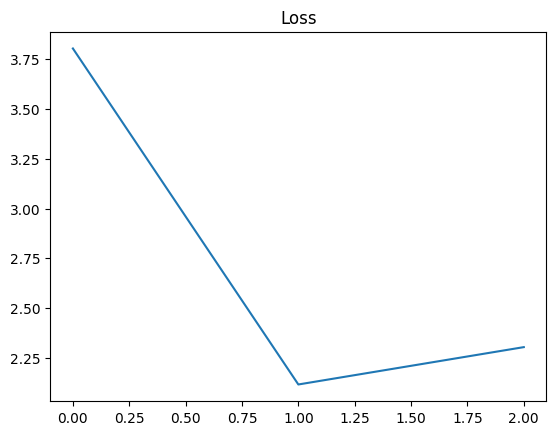

In [165]:
sentences = cn_sent

max_sentence_length = max([len(sent) for sent in sentences])
padded_sentences = [sent + ['<pad>'] * (max_sentence_length - len(sent)) for sent in sentences]

cn_vocab = {'<pad>': 0, '<s>': 1, '</s>': 2}
idx = 3
for sent in padded_sentences:
    for word in sent:
        if word not in cn_vocab:
            cn_vocab[word] = idx
            idx += 1

indexed_sentences = [[cn_vocab[word] for word in sent] for sent in padded_sentences]

# Initialize the model
vocab_size = len(cn_vocab)
embedding_dim = 100
hidden_dim = 128
cn_model = SentenceGenerationModel(vocab_size, embedding_dim, hidden_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cn_model.parameters(), lr=0.001)

# Training loop
dataset = SentenceDataset(indexed_sentences)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

losses = []

num_epochs = 3
for epoch in tqdm(range(num_epochs)):
    for batch in dataloader:
        optimizer.zero_grad()
        batch_input = batch[:, :-1]
        batch_target = batch[:, 1:]
        hidden = (torch.zeros(1, batch.size(0), hidden_dim),
                  torch.zeros(1, batch.size(0), hidden_dim))

        output, _ = cn_model(batch_input, hidden)
        loss = criterion(output.permute(0, 2, 1), batch_target)
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
plt.title('Loss')
plt.plot(losses)

In [166]:
generated_sentence = generate_sentence(cn_model,cn_vocab)
print(generated_sentence)

<s> 貴 谷 職 祖 奈 套 瑞 開 約 接 始 盤 果 第 月 F 病 泥 馬 聲 G 避 驗 存 境 匯 脖 窄 獨 抵 淚 嫌 週 違 耶 呢 i 促 居 功 鉛 植 傾 博 掀 註 遇 覺 貿 進 擺 愍 匈 晉 帳 燒 魯 憲 n 際 致 窄 肥 警 坐 排 誤 氣 被 點 期 普 肺 7 兵 i 葺 照 二 那 是 敦 鄉 剔 還 移 牢 貝 凍 療 兔 圳 玩 浴 端 賴 傳 弗 奠


Here we can see already that the output from neural network is not as good as the one generated by N-gram model.

##Evaluation

The evaluation step will still be calculating perplexity.


In [167]:
max_sentence_length = max([len(sent) for sent in cn_sent])
padded_sentences = [sent + ['<pad>'] * (max_sentence_length - len(sent)) for sent in cn_test_set]

indexed_test_sentences = []
for sent in padded_sentences:
    ls = []
    for word in sent:
        if word in cn_vocab.keys():
            ls.append(cn_vocab[word])
        else:
            ls.append(0)
    indexed_test_sentences.append(ls)

test_dataset = SentenceDataset(indexed_test_sentences)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()

total_loss = 0.0
total_words = 0

with torch.no_grad():
    cn_model.eval()
    for batch in test_dataloader:
        batch_input = batch[:, :-1]
        batch_target = batch[:, 1:]
        hidden = (torch.zeros(1, batch.size(0), hidden_dim),
                  torch.zeros(1, batch.size(0), hidden_dim))

        output, _ = cn_model(batch_input, hidden)
        loss = criterion(output.permute(0, 2, 1), batch_target)
        total_loss += loss.item() * batch_target.numel()
        total_words += batch_target.numel()

perplexity = math.exp(total_loss / total_words)

print(f"Perplexity for Chinese model on the test set: {perplexity:.2f}")

Perplexity for Chinese model on the test set: 10.43


In [168]:
max_sentence_length = max([len(sent) for sent in en_sent])
padded_sentences = [sent + ['<pad>'] * (max_sentence_length - len(sent)) for sent in en_test_set]

indexed_test_sentences = []
for sent in padded_sentences:
    ls = []
    for word in sent:
        if word in cn_vocab.keys():
            ls.append(cn_vocab[word])
        else:
            ls.append(0)
    indexed_test_sentences.append(ls)

test_dataset = SentenceDataset(indexed_test_sentences)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()

total_loss = 0.0
total_words = 0

with torch.no_grad():
    en_model.eval()
    for batch in test_dataloader:
        batch_input = batch[:, :-1]
        batch_target = batch[:, 1:]
        hidden = (torch.zeros(1, batch.size(0), hidden_dim),
                  torch.zeros(1, batch.size(0), hidden_dim))

        output, _ = en_model(batch_input, hidden)
        loss = criterion(output.permute(0, 2, 1), batch_target)
        total_loss += loss.item() * batch_target.numel()
        total_words += batch_target.numel()

perplexity = math.exp(total_loss / total_words)

print(f"Perplexity for English model on the test set: {perplexity:.2f}")

Perplexity for English model on the test set: 1.53


The results of both model are confusing. I don't quite understand why the neural network model behave in such a weird way, but I can tell that the English model is better than the Chinese model just by looking at the randomly generated sentences. Perhaps other evaluation methods could make more sense. But so far, neural network model that I created generate less coherent sentences than N-gram models.